<a href="https://colab.research.google.com/github/PuruGupta1699/NOC-Mapping-Problem/blob/main/encode_attend_navigate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensure GPU is accessible

_Be sure to enable GPU : `Edit` > `Notebook settings`_

In [1]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Thu Feb 24 15:25:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Clone the repo

In [2]:
!git clone https://github.com/astariul/encode-attend-navigate-pytorch.git
%cd encode-attend-navigate-pytorch

Cloning into 'encode-attend-navigate-pytorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 191 (delta 116), reused 156 (delta 82), pack-reused 0
Receiving objects: 100% (191/191), 31.08 KiB | 252.00 KiB/s, done.
Resolving deltas: 100% (116/116), done.
/content/encode-attend-navigate-pytorch


# Install dependencies

In [3]:
!pip install -r requirements.txt -qqq

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
     |████████████████████████████████| 181 kB 38.0 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 144 kB 51.8 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.


# Connect wandb

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Generate and view some data

<class 'list'>
50


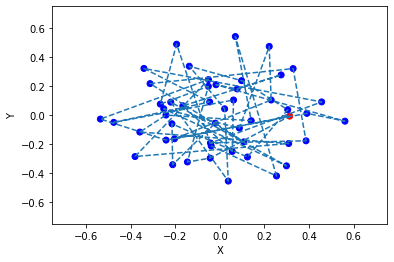

In [6]:
from data import DataGenerator

dataset = DataGenerator()
input_batch = dataset.test_batch(batch_size=128, max_length=50, dimension=2, seed=123)
print(type(input_batch))
print(len(input_batch[0]))
dataset.visualize_2D_trip(input_batch[0])

# Train

### Change configuration

In [7]:
import wandb
from main import load_conf, Agent, Trainer, DataGenerator

conf = load_conf()

conf["enc_stacks"] = 1
conf["lr"] = 0.0002
conf["p_dropout"] = 0.1

### Run training

In [8]:
wandb.init(project=conf.proj_name, config=dict(conf))

agent = Agent(embed_hidden=conf.embed_hidden, enc_stacks=conf.enc_stacks, ff_hidden=conf.ff_hidden, enc_heads=conf.enc_heads, query_hidden=conf.query_hidden, att_hidden=conf.att_hidden, crit_hidden=conf.crit_hidden, n_history=conf.n_history, p_dropout=conf.p_dropout)
wandb.watch(agent)

dataset = DataGenerator()

# Run training
trainer = Trainer(conf, agent, dataset)
trainer.run()

# Save trained agent
torch.save(agent.state_dict(), conf.model_path)

wandb: Currently logged in as: psg1699 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/content/encode-attend-navigate-pytorch/trainer.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  input_batch = torch.Tensor(input_batch).to(self.device)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  overriding this method with custom logic.


# Test

Reward (before 2 opt) 5.728453636169434
Reward (with 2 opt) 5.591304421853245


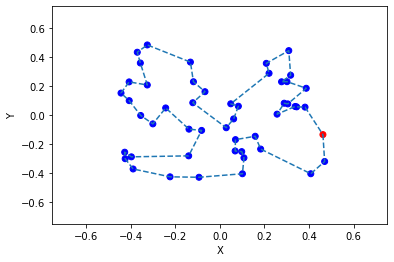

Reward (before 2 opt) 5.988188743591309
Reward (with 2 opt) 5.856096394681245


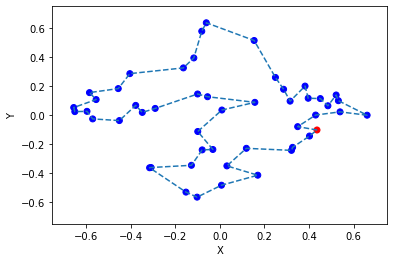

Reward (before 2 opt) 5.877534866333008
Reward (with 2 opt) 5.855043803048406


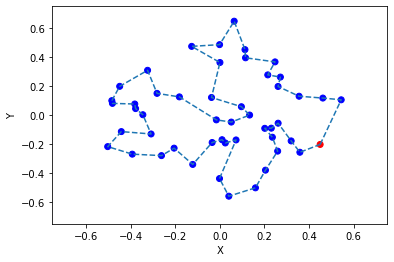

Reward (before 2 opt) 6.346138954162598
Reward (with 2 opt) 6.193989449693636


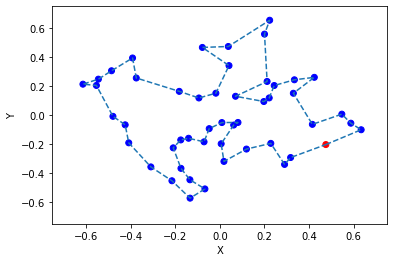

Reward (before 2 opt) 6.154412269592285
Reward (with 2 opt) 6.0325081418131


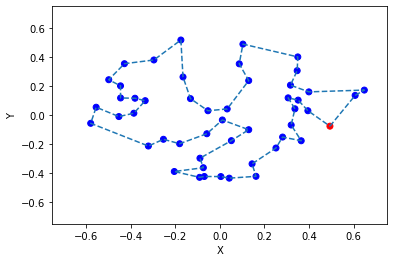

Reward (before 2 opt) 5.894434452056885
Reward (with 2 opt) 5.817541657571289


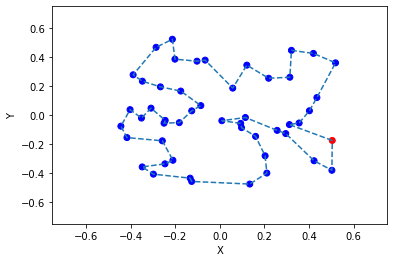

Reward (before 2 opt) 5.920721054077148
Reward (with 2 opt) 5.737479830382953


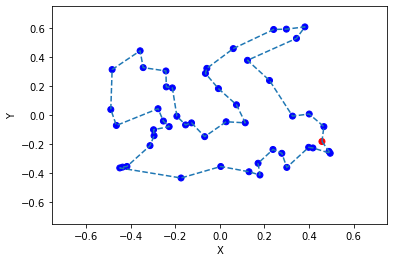

Reward (before 2 opt) 5.736616611480713
Reward (with 2 opt) 5.65168732941519


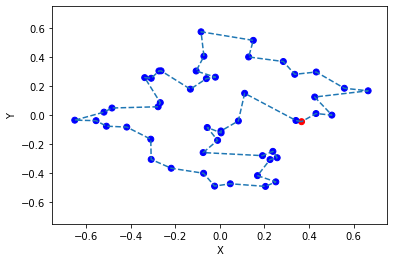

Reward (before 2 opt) 5.703374862670898
Reward (with 2 opt) 5.67899787381843


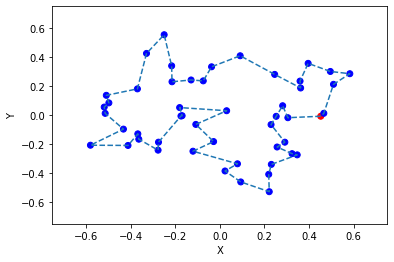

Reward (before 2 opt) 6.036913871765137
Reward (with 2 opt) 5.902112967638378


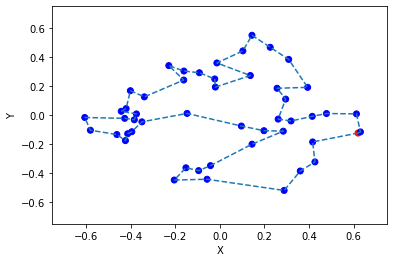

In [9]:
from trainer import reward_fn


device = torch.device(conf.device)

# Load trained agent
agent = Agent(embed_hidden=conf.embed_hidden, enc_stacks=conf.enc_stacks, ff_hidden=conf.ff_hidden, enc_heads=conf.enc_heads, query_hidden=conf.query_hidden, att_hidden=conf.att_hidden, crit_hidden=conf.crit_hidden, n_history=conf.n_history, p_dropout=conf.p_dropout)
agent.load_state_dict(torch.load(conf.model_path))
agent.eval()
agent = agent.to(device)

running_reward = 0
for _ in range(conf.test_steps):
    input_batch = dataset.test_batch(conf.batch_size, conf.max_len, conf.dimension, shuffle=False)
    tensor_batch = torch.Tensor(input_batch).to(device)

    tour, *_ = agent(tensor_batch)

    reward = reward_fn(tensor_batch, tour)

    # Find best solution
    j = reward.argmin()
    best_tour = tour[j][:-1].tolist()

    # Log
    running_reward += reward[j]

    # Display
    print('Reward (before 2 opt)', reward[j].item())
    opt_tour, opt_length = dataset.loop2opt(input_batch[0][best_tour])
    print('Reward (with 2 opt)', opt_length)
    dataset.visualize_2D_trip(opt_tour)

wandb.run.summary["test_reward"] = running_reward / conf.test_steps